In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random
import time
import pandas as pd
import math
import csv
import os

t0=time.time()
###########################################################
###########################################################
# Acordate que en casa los ldata tienen que empezar con Tests/
# En la facultad va directo el nombre del archivo
############################################################
############################################################

def scan(cant,lista):
    i=0
    for x in lista:
        print(x)
        i+=1
        if i>cant:
            break
            
def Tiempo():
    t1=time.time()
    print("Esto tardó {} segundos".format(t1-t0))


def ldata(archive):
        f = open(archive)
        data = []
        for line in f:
            col = line.split("\t")
            col = [x.strip() for x in col]
            data.append(col)
        return data 
    
# Vamos a leer los archivos con esta celda. Al darle la dirección de la carpeta Datos, lo que estoy sacando
# son los nombres de todos los archivos en esa carpeta.
#--------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Datos")]

##############################################################################
# Los primero dos elementos de CarpCheck no les des bola, porque son
# la mismísma carpeta en la que estás y porque el segundo es ipynb checkpoints
# Eso es algo del notebook, no del TP.
##############################################################################

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[1] es el nombre de la carpeta


for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#----------------------------------------------------------------------------

# Leo mi archivo

# Datos = ldata("{}/{}".format(Archivos_Datos[0],Archivos_Datos[1]))

# # Levanto los valores de N y T del nombre de mi archivo. Es importante recordar que mis
# # archivos tienen nombres de la forma: Datos_Evolucion_Opinion_N=$_T=$_K=$

# N = int(Archivos_Datos[1].split("_")[3].split("=")[1])
# T = int(Archivos_Datos[1].split("_")[4].split("=")[1])
# K = float(Archivos_Datos[1].split("_")[5].split("=")[1])

# # Hagamos un gráfico de estos datos. Por lo menos del caso K=0
# # Quiero hacer un gráfico en el que se vea que las opiniones van cayendo a cero.
# # La idea es hacer una sumatoria del valor cuadrado de las opiniones de cada uno.

# # Primero me armo una lista que tenga todos los valores que están en Datos sin ese
# # espacio que está en la primer coordenada. También estaría bueno pasar los strings
# # a floats.

# Opiniones = []
# for fila in Datos[5:len(Datos)]:
#     # Arranco desde 5 porque las primeras son títulos y las matrices de Adyacencia y Superposicion
#     fila2 = [float(x) for x in fila[1:len(fila)]]
#     Opiniones.append(fila2)
#     # Debería haber una forma más compacta de hacer esto. Quizás podría hacer una función de esto.
#     # La otra es meter un espacio en los títulos también, para al levantar datos eliminar
#     # eso de una también. Y luego el mismo Datos que tenga todos los números y listo.

# # Me armo los vectores X e Y que voy a graficar
# X = np.arange(0,len(Opiniones))
# Y1 = []
# Y2 = []
# for i in range(len(Opiniones)):
#     # Obtengo los valores cuadrados de todos los tópicos
#     T0 = [t**2 for t in Opiniones[i][0:len(Opiniones[i]):T]]
#     T1 = [t**2 for t in Opiniones[i][1:len(Opiniones[i]):T]]
#     # Ahora los sumo y los agrego a mis vectores Y
#     Y1.append(np.sum(T0)/len(T0))
#     Y2.append(np.sum(T1)/len(T1))

    
# plt.figure(figsize=(15,6))
# plt.plot(X,Y1, "--b",label="Topico 1" ,linewidth = 3)
# plt.plot(X,Y2, "--r",label="Topico 2" ,linewidth = 3)
# plt.rcParams.update({'font.size': 18})
# plt.xlabel("Iteraciones")
# plt.ylabel("Promedio de Opiniones Cuadradas")
# plt.title("Evolución de las opiniones")
# plt.legend()
# plt.grid()
# plt.show()





Tiempo()

Esto tardó 0.0009987354278564453 segundos


In [2]:
t0 = time.time()

Conjunto = set([1,2,3,4,5,4,3,4,5,6,7,2,1,4,2,3,4,5])

for i in Conjunto:
    print(i)



Tiempo()

1
2
3
4
5
6
7
Esto tardó 0.0 segundos


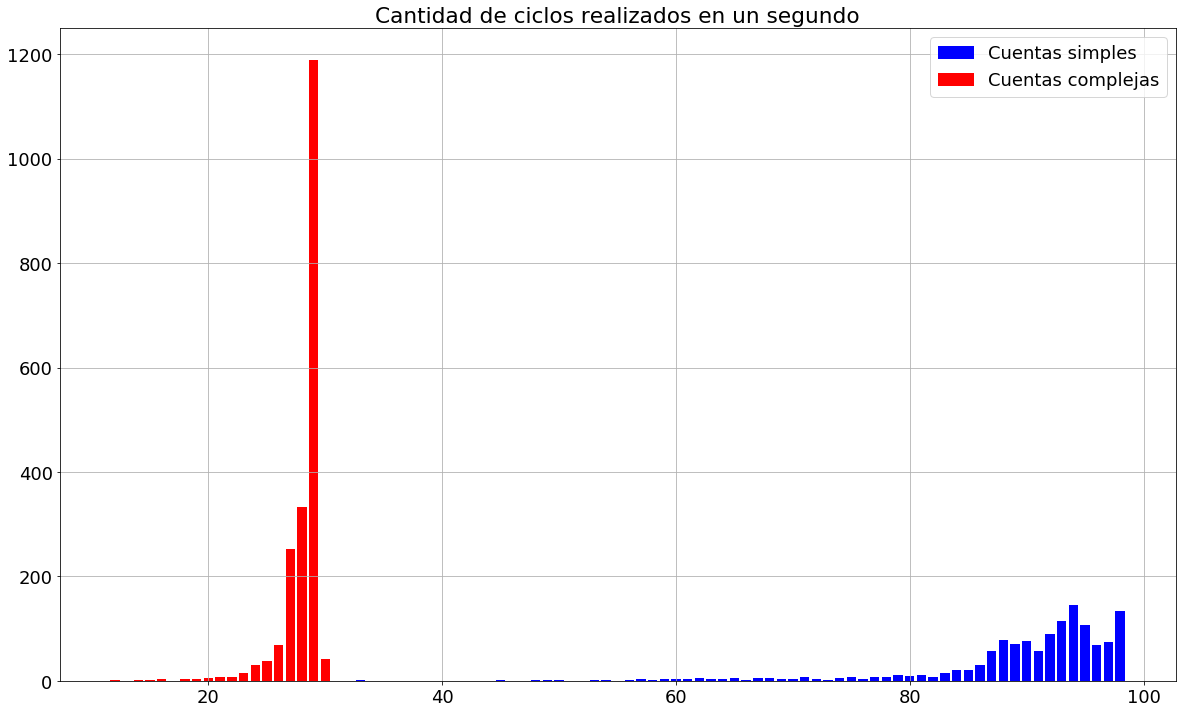

Esto tardó 0.5310208797454834 segundos


In [22]:
t0 = time.time()

# Acá voy a hacer el histograma de cantidad de ciclos realizados para una serie de cuentas simples
# versus una serie de cuentas complejas. La idea es ver si hay una ganancia de tiempo al realizar
# cuentas simples de multiplicación, división, suma y resta versus cálculos de tanh.

Datos = ldata("Histograma_Ciclos")

Simples = [int(x) for x in Datos[0][1:len(Datos[0])]]
Complejos = [int(x) for x in Datos[1][1:len(Datos[1])]]

Bins = [x for x in range(12,100)]

[Hist1,Bin1] = np.histogram(Simples, bins = Bins)
[Hist2,Bin2] = np.histogram(Complejos, bins = Bins)

plt.figure(figsize=(20,12))

plt.bar(Bin1[0:len(Bin1)-1], Hist1,color = "blue", label = "Cuentas simples")
plt.bar(Bin2[0:len(Bin2)-1], Hist2,color = "red", label = "Cuentas complejas")
plt.rcParams.update({'font.size': 18})
plt.title("Cantidad de ciclos realizados en un segundo")
plt.grid()
plt.legend()
plt.show()

# Al final se puede ver que obviamente hay ganancia, para un mismo intervalo de tiempo, en promedio
# realizo aproximadamente 4 ciclos más con cuentas simples que con cuentas complejas.

Tiempo()

In [62]:
# Acá lo que hay es una función que armé para distribuir un índice que indique el color
# que le corresponde al estado final que alcanza un agente al evolucionar el sistema.

def Indice_Color(vector,Divisiones):
    # Primero calculo el ángulo
    Vhor = [1,0] # Este vector representa la horizontal
    vector_unitario = vector/np.linalg.norm(vector)
    Producto_escalar = np.dot(Vhor,vector_unitario)
    Angulo = np.arccos(Producto_escalar)
    
    # Le hago ajuste considerando el cuadrante del vector
    if vector[1] < 0:
        Angulo = 2*math.pi-Angulo
    
    
    # Ahora calculo el valor de división entera y el Resto
    Delta = (2*math.pi)/Divisiones
    Dividendo = Angulo/Delta
    D = math.floor(Dividendo)
    R = Dividendo - D
    
    # Compruebo en qué casillero cae el ángulo y returneo el índice
    if R <= Delta/2:
        return D # En este caso el ángulo se encuentra entre (D*Delta-Delta/2,D*Delta+Delta/2]
    elif R > Delta/2:
        return (D+1)%360 # En este caso el ángulo se encuentra entre ((D+1)*Delta-Delta/2,(D+1)*Delta+Delta/2]
    
    
a = Indice_Color([1,-1/50],360)
print(a)

359


In [ ]:
# Lo que hay en esta celda es un análisis inútil que hice de mis datos de Error Cuadrático.
# Tan inútil resultó que ahora el Error Cuadrático es la Variación Promedio de las Opiniones.
# Lo voy a guardar acá como para que esté en algún lado ya que está escrito y quizás tiene
# algo que se le pueda rescatar en el futuro.

#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################

t0= time.time()

# En esta celda voy a trabajar por armar un criterio de corte que parezca razonable.
# Estoy dispuesto a ser más liberal que conservador. Es decir, estoy dispuesto a 
# que el sistema corra de más y no de menos.

#--------------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Datos Corte")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos Corte
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#----------------------------------------------------------------------------

# Tengo dos tipos de archivos. Los de datos de opiniones tienen el siguiente formato:
# Datos_Evolucion_Opinion_N=$_T=$_K=$
# Los de datos de error cuadrático tienen el formato: Datos_Errcuad_DiferenciaOpi_N=$_T=$_K=$
# Armemos dos listas, una con los nombres de las opiniones y otra con los nombres de los errores.
# En ambas listas el primer elemento va a ser la carpeta en la que se encuentran los datos.
# En esta celda voy a armar la lista de Nombres de Errores.
        
Nombres_Errores = [Archivos_Datos[0]]
for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
    if nombre.split("_")[1] == "Errcuad":
        Nombres_Errores.append(nombre)

# Bien, las listas de nombres de archivos ya se arman correctamente

#-------------------------------------------------------------------------------------------

# Como el valor de K para cada batch puede variar, voy a intentar descubrir los valores
# mínimos y máximos de los K involucrados.

Kmin = int(float(Nombres_Errores[1].split("_")[5].split("=")[1]))
Kmax = int(float(Nombres_Errores[1].split("_")[5].split("=")[1]))

# Defino un Kmin y Kmax inicial cualquiera, pero que esté dentro del conjunto total

for nombre in Nombres_Errores[1:len(Nombres_Errores)]:
    K = int(float(nombre.split("_")[5].split("=")[1]))
    Kmin = min(K,Kmin)
    Kmax = max(K,Kmax)

# Bien, esto ya me obtiene los valores de Kmin y Kmax correctamente.
# Acá tenés que tener cuidado, porque originalmente K es un número float.
# En esta ocasión tomé valores de K enteros, pero podría no haberlo hecho.
# Después habrá que corregir eso.

#-------------------------------------------------------------------------------------------
plt.figure(figsize=(20,12))

for influencia in range(Kmin,Kmax+1):
    X0 = [] # Acá voy a guardar los números de agentes
    Y0 = [] # Acá voy a guardar la cantidad de ceros que aparecen en los errores
    X = [] # Acá voy a guardar los números de agentes ordenados
    Y = [] # Acá voy a guardar la cantidad de ceros que aparecen en los errores de manera ordenada

    for nombre in Nombres_Errores[1:len(Nombres_Errores)]:
        
        # Levanto los valores de N, K y T del nombre de mi archivo. Es importante recordar que mis
        # archivos tienen nombres de la forma: Datos_Errcuad_DiferenciaOpi_N=$_T=$_K=$

        N = int(nombre.split("_")[3].split("=")[1])
        T = int(nombre.split("_")[4].split("=")[1])
        K = float(nombre.split("_")[5].split("=")[1])

        # Los valores de N, T y K se levantan correctamente

        #--------------------------------------------------------------------------------------------
        # Reviso que esté mirando los datos que tengan el valor de K que busco antes de graficar.
        if influencia==K:

            # Levanto los datos del archivo original y separo los datos en tres listas.
            # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

            Datos = ldata("{}/{}".format(Nombres_Errores[0],nombre))

            # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
            # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
            Err = [float(x) for x in Datos[0][1:len(Datos[0])]]

            # Tengo correctamente levantados los datos de los errores

            #--------------------------------------------------------------------------------------------
            
            X0.append(N)
            Y0.append(Err.count(0))
            
    A = [n for n in X0]
    A.sort()
    for n in A:
        i = X0.index(n)
        X.append(X0[i])
        Y.append(Y0[i])
        
    plt.plot(X,Y,"--",label="K={}".format(influencia) ,linewidth = 3)

plt.rcParams.update({'font.size': 18})
plt.xlabel("Agentes")
plt.ylabel("Cantidad de ceros")
plt.title("Cantidad de ceros en los errores según cantidad de agentes y según K")
plt.grid()
plt.legend()
#     plt.savefig("../Imagenes/Estabilizacion/Ceros_vs_Agentes_T={}.png".format(agentes,T),bbox_inches = "tight")
plt.show()


---------------------------------------------------------------------------------------------------

Otra cosa que se me ocurre es graficar algunas líneas horizontales que marquen los valores
del 50%, 40% y así hasta el 10% y 5% del máximo valor de error. Como una forma gráfica de ver
qué parte del gráfico se encuentra en qué regiones.

for nombre in Nombres_Errores[1:len(Nombres_Errores)]:
        
    # Levanto los valores de N y T del nombre de mi archivo. Es importante recordar que mis
    # archivos tienen nombres de la forma: Datos_Errcuad_DiferenciaOpi_N=$_T=$_K=$

    N = int(nombre.split("_")[3].split("=")[1])
    T = int(nombre.split("_")[4].split("=")[1])
    K = float(nombre.split("_")[5].split("=")[1])

    # Los valores de N, T y K se levantan correctamente

    #--------------------------------------------------------------------------------------------

    # Levanto los datos del archivo original y separo los datos en tres listas.
    # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

    Datos = ldata("{}/{}".format(Nombres_Errores[0],nombre))

    # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
    # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
    Err = [float(x) for x in Datos[0][1:len(Datos[0])]]

    # Tengo correctamente levantados los datos de los errores

    #--------------------------------------------------------------------------------------------

    # Como lo único que tengo que graficar es el Error, ya tengo los datos armados. Sólo necesito
    # un vector X asociado.

    X = np.arange(0,len(Err))

    plt.figure(figsize=(20,12))
    plt.semilogy(X,Err, "--",linewidth = 3)

    plt.axhline(y=max(Err)*0.005,label="0.5%",linewidth=3)

    # Este código de acá para que el sistema vaya cambiando colores de cada recta. Es un código heredado.
    # Lo saqué de Stack Overflow. Me hago la idea de qué hace, pero ni idea de qué son exactamente
    # estas funciones.
    color=cm.rainbow(np.linspace(0,1,10))
    # En el linspace, el tercer número es justamente el número de curvas que vas a graficar.
    # Eso después es la cantidad de números en la que vas a iterar a i en el zip
    for i,c in zip(range(1,11),color):
        plt.axhline(y=max(Err)*0.02*i,label="{}%".format(i*2), c=c ,linewidth=3)

    plt.rcParams.update({'font.size': 18})
    plt.xlabel("Iteraciones")
    plt.ylabel("Suma de diferencias cuadradas")
    plt.title("Umbrales de valor de error para sitema de N={} K={}".format(N,K))
    plt.grid()
    plt.legend()
#     plt.savefig("../Imagenes/Umbrales Error/Umbrales_N={}_T={}_K={}.png".format(N,T,K),bbox_inches = "tight")
    plt.close()


Tiempo()